<a href="https://colab.research.google.com/github/fabiocarrara/mbd-dlmra/blob/main/ol1_image_representation_search_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DLMRA OpenLab \#1
-----------------

# Image Representations for Similarity Search, Clustering, and Classification

You'll learn to:

*   Represent images using features extracted from pretrained CNNs.
*   Search images by visual similarity in an image database.
*   Cluster an image database by visual similarity.
*   Build simple image classifiers based on pretrained representations.


## Getting Started

We will use [Kaggle](https://www.kaggle.com/) as our source of datasets. This let us download datasets directly from Kaggle to Colab without manually upload the data at the beginning of every session.

- Register on Kaggle (you can login with a Google Account).
- Go to Account Settings > "Account" Tab > Click on "Create New API Token".
- Save the generated `kaggle.json` file somewhere on your PC.

Next, we install the `kaggle` command line utility on Colab.

In [ ]:
!pip install -q kaggle

Upload the `kaggle.json` file to Colab...

In [ ]:
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


... and let's put it in the right place and give it the right file permissions.

In [ ]:
%%bash
mkdir -p ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json

Now, we can download datasets using the `kaggle`.
Let's download the dataset used in this exercise: `vikashrajluhaniwal/fashion-images`.

More info on the dataset on [its Kaggle page](https://www.kaggle.com/vikashrajluhaniwal/fashion-images).





In [ ]:
!kaggle datasets download -d vikashrajluhaniwal/fashion-images --unzip

 95% 317M/335M [00:05<00:00, 58.1MB/s]
100% 335M/335M [00:06<00:00, 58.3MB/s]


In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from pathlib import Path
from tqdm.auto import tqdm
from skimage.transform import resize

import matplotlib
import matplotlib.pyplot as plt

import random

%matplotlib inline

## Data Loading

Let's inspect the data.

In [ ]:
image_paths = Path('data').rglob('*.jpg')
image_paths = sorted(image_paths)
image_paths[:5]

[PosixPath('data/Apparel/Boys/Images/images_with_product_ids/10054.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/10649.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/10671.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/12840.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/12844.jpg')]

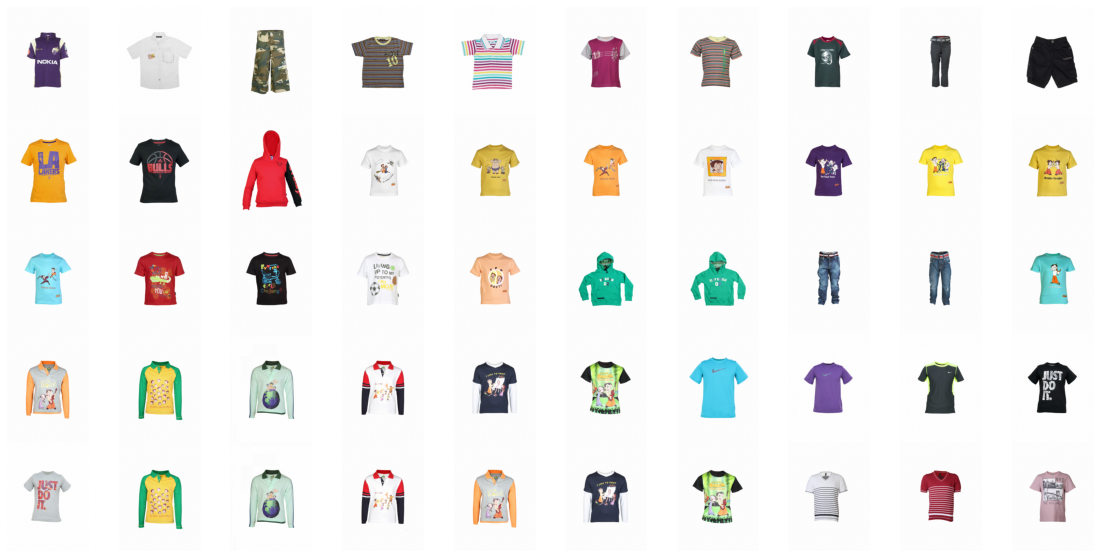

In [ ]:
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
for ax, image_path in zip(axes.flatten(), image_paths):
  image_np = plt.imread(image_path)
  image_np = resize(image_np, (400, 300))
  ax.imshow(image_np)
  ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

Consider a (potentially large) database of images and a set of query images.
Our goal is to retrieve images from the database that are visually similar to the queries.

Let's select from our dataset two subset of images that will comprise the *database* and the *queries*.

In [ ]:
nq = 15  # number of queries
ndb = 500  # number of samples in the database

selected_image_paths = random.sample(image_paths, ndb + nq)
db_image_paths = selected_image_paths[:ndb]
q_image_paths = selected_image_paths[-nq:]
q_image_paths[:5]

[PosixPath('data/Footwear/Men/Images/images_with_product_ids/5050.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/40160.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/33309.jpg'),
 PosixPath('data/Apparel/Boys/Images/images_with_product_ids/34182.jpg'),
 PosixPath('data/Footwear/Women/Images/images_with_product_ids/4147.jpg')]

## Image Representation

We will use a pretrained model to extract features from images and use them as compact image representations.
The choice of the model is essential to get good representations for your target task (e.g. a model trained on classifying dog breeds will have a hard time creating good representations for images of flowers).

A lot of pretrained models are available on [TensorFlow Hub](https://tfhub.dev) and can be easily downloaded and used in Keras with the `tensorflow_hub.KerasLayer` API.

Check out [this list](https://tfhub.dev/google/collections/experts/bit/1) of Google's BiT models (Big Transfer, specifically thought for feature extraction) that are pretrained on specific subsets of the ImageNet-21k dataset.

_NOTE: If you need a specialized model, you will need to fine-tune a pretrained model on a small dataset of images you are interested in discerning._


In [ ]:
# a model pretrained on ImageNet-21k
# model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1")
model = hub.KerasLayer("https://tfhub.dev/google/experts/bit/r50x1/in21k/consumer_goods/1")

`model` is a Keras module that can be called on tensor images and returns a feature vector (2048-d for BiT models).

Let's prepare the model pipeline by defining input preprocessing and feature post-processing.

In [ ]:
def load_image(path):
  image_data = tf.io.read_file(path)
  image = tf.image.decode_image(image_data, channels=3, expand_animations=False)
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.expand_dims(image, axis=0)
  return image

def resize_images(images):
  # return tf.image.resize(images, (363, 272))
  return tf.image.resize(images, (512, 512), preserve_aspect_ratio=True)

def l2_normalize(feature_vector):
  return tf.math.l2_normalize(feature_vector, axis=1)

Let's extract feature vectors from a bunch of images. We use the `tf.data.Dataset` API (specifically `.map()`) to apply input preprocessing, feature extraction, and feature postprocessing.

_NOTE: when using `.map()`, all the processing is deferred. Data will be processed when we will iterate on the dataset asking for computation results._

In [ ]:
db = list(map(str, db_image_paths))
db = tf.data.Dataset.from_tensor_slices(db)
db = db.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
db = db.map(resize_images, num_parallel_calls=tf.data.AUTOTUNE)
db = db.prefetch(5)

db_features = db.map(model)  # apply model to get features
db_features = db_features.map(l2_normalize)  # apply postprocessing (normalize features)

total = len(db_features)
db_features = db_features.as_numpy_iterator()  # we want results as numpy arrays
db_features = tqdm(db_features, total=total)  # add a progress bar with tqdm
db_features = list(db_features)  # get all features in a list 
db_features = np.concatenate(db_features)  # concatenate rows to get a unique matrix
db_features.shape

(500, 2048)

## Image Similarity Search

Once we have feature vectors representations, we can search similar by comparing the features vectors instead of pixels.

We will compare feature vectors using the cosine similarity
$$
 \cos(a, b) = \frac{a \cdot b}{\left\lVert a \right\rVert_2 \left\lVert b \right\rVert_2},
$$
that ranges between 0 (low similarity) and 1 (high similarity).

On normalized features ($\left\lVert a \right\rVert_2 = \left\lVert b \right\rVert_2 = 1$), the cosine similarity is equivalent to the dot product $a \cdot b$. 

Let's select some query images for which we want to retrieve similar images in our database.
We will perform a brute-force search (a.k.a. sequential scan) where we compare the queries' feature vectors with all the databases' feature vectors. (For $Q$ queries and $D$ database images, we will compute $N \times D$ scores).

In [ ]:
# extract features of queries
queries = list(map(str, q_image_paths))
queries = tf.data.Dataset.from_tensor_slices(queries)
queries_features = queries.map(load_image).map(resize_images).map(model).map(l2_normalize).as_numpy_iterator()
queries_features = tqdm(queries_features, total=nq)
queries_features = np.concatenate(list(queries_features))
queries_features.shape

(15, 2048)

We can compute all the dot products between queries $F_\text{q} \in \mathbb{R}^{Q \times 2048}$ and database feature vectors $F_\text{db} \in \mathbb{R}^{D \times 2048}$ using a single matrix multiplication
$$
S = \{s_{ij}\}= F_\text{q} F_\text{db}^T \,,
$$
where the $s_{ij}$ element of $S$ is the cosine similarity between the $i$-th query $f_\text{q}^i$ and the $j$-th database feature vector $f_\text{db}^j$
$$
s_{ij} = f_\text{q}^i \cdot f_\text{db}^j \,.
$$


In [ ]:
scores = queries_features.dot(db_features.T)
scores.shape

(15, 500)

In [ ]:
nq, ndb = scores.shape

k = 5
sorted_scores = scores.argsort(axis=1)[:, ::-1]  # sort descending per row
topk = sorted_scores[:, :k]  # get **indices** of the topk images for each row
topk_scores = scores[np.arange(nq)[:, None], topk]  # use the indices to get the topk scores (magic slicing version)
# topk_scores = np.concatenate([scores[i, topk[i]] for i in range(nq)])  # get topk scores (comprehensible version)
topk_scores

array([[0.9407593 , 0.9306259 , 0.9268147 , 0.92441154, 0.92299277],
       [1.0000002 , 0.9699577 , 0.96677387, 0.9589789 , 0.94561476],
       [0.9611631 , 0.9575129 , 0.92574704, 0.92430997, 0.9205341 ],
       [0.9996841 , 0.9459651 , 0.91358817, 0.91281915, 0.90982604],
       [0.9468673 , 0.94045365, 0.9320928 , 0.9274408 , 0.9261445 ],
       [0.8997191 , 0.860334  , 0.8499182 , 0.84881467, 0.84796613],
       [0.9414113 , 0.93838096, 0.93353975, 0.9333048 , 0.9329649 ],
       [1.0000001 , 0.9241472 , 0.8988716 , 0.8837626 , 0.8837626 ],
       [0.9656279 , 0.9295023 , 0.92704993, 0.925469  , 0.9242278 ],
       [0.9526132 , 0.94292283, 0.9357673 , 0.9357673 , 0.92121094],
       [0.9241013 , 0.80528426, 0.7874652 , 0.7741424 , 0.76186144],
       [0.89604795, 0.8827627 , 0.8720613 , 0.8679395 , 0.8643352 ],
       [0.95472485, 0.9546673 , 0.94532895, 0.94378775, 0.9435121 ],
       [0.9292882 , 0.9088784 , 0.9083495 , 0.90477586, 0.90422976],
       [0.9099526 , 0.907113  , 0.

Let's define a helper function to select some images from a `tf.data.Dataset` pipeline.

In [ ]:
def unpad_image(image_np):
    # remove some whitespace around the images
    image_np = np.stack([image_np, image_np, image_np], axis=-1) if image_np.ndim < 3 else image_np
    rr, cc = np.nonzero((image_np != 255).any(axis=2))
    y0, y1 = rr.min(), rr.max()
    x0, x1 = cc.min(), cc.max()
    return image_np[y0:y1+1, x0:x1+1]

def show_images(paths, figsize=None):
  n_images = len(paths)
  fig, axes = plt.subplots(1, n_images, figsize=figsize)
  for ax, path in zip(axes, paths):
    image_np = plt.imread(path)
    image_np = unpad_image(image_np)
    image_np = resize(image_np, (363, 266))
    ax.imshow(image_np)
    ax.set_xticks([])
    ax.set_yticks([])
  
  return fig

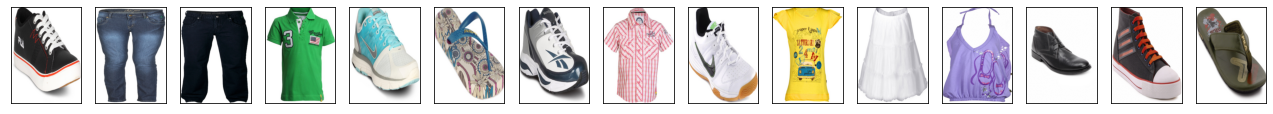

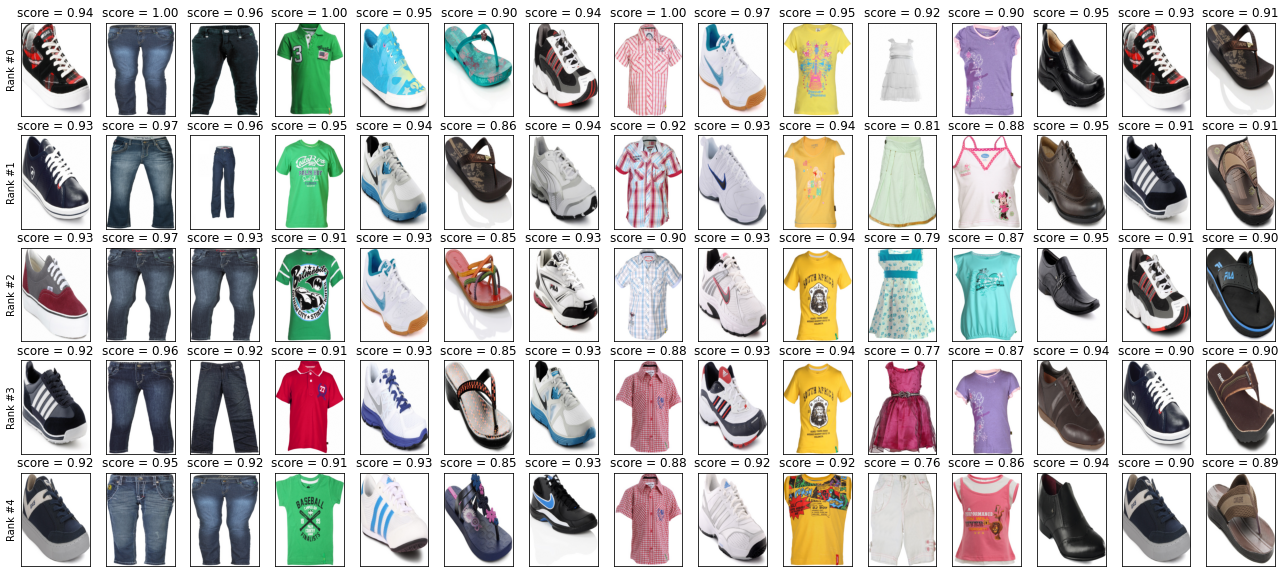

In [ ]:
# show queries
fig = show_images(q_image_paths, figsize=(1.5*nq, 5))

# show topk similar 
fig, axes = plt.subplots(k, nq, figsize=(fig.get_figwidth(), 2*k))
for j in range(k):
  axes[j, 0].set_ylabel(f'Rank #{j}')
  for i in range(nq):
    image_np = plt.imread(db_image_paths[topk[i, j]])
    image_np = unpad_image(image_np)
    image_np = resize(image_np, (363, 266))
    axes[j, i].imshow(image_np)
    axes[j, i].set_title('score = {:.2f}'.format(topk_scores[i, j]))
    axes[j, i].set_xticks([])
    axes[j, i].set_yticks([])

## Image Clustering

Image representations can be used to explore an image dataset via clustering.
We will use kMeans on feature vectors to group similar images together.

In [ ]:
import itertools
from collections import Counter
from sklearn.cluster import KMeans

In [ ]:
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit_predict(db_features)  # run kmeans on the db features to find centroids
# kmeans.cluster_centers_  # uncomment to see the cluster centroids

array([ 3,  8, 15, 17,  2, 13,  2, 18,  8,  7, 13,  6,  2, 16,  3, 19,  3,
        5,  2, 14, 15,  7, 13,  9, 15,  7,  2,  2,  6,  0,  8,  2, 14,  3,
        8, 18, 17, 13, 13,  2,  1,  5, 12, 13, 11,  5,  2, 12,  2,  5,  4,
        4,  5,  4,  2,  7,  0,  1,  2,  3, 15,  7,  2,  4, 18, 18,  5,  1,
        1,  0, 13,  4,  6,  2,  3,  0, 18, 13, 17,  3, 14,  8, 13, 14,  2,
       14,  5, 17,  5, 15,  5,  0,  3,  3,  1, 15,  1,  2,  2, 18,  3,  6,
        5, 10, 18,  7,  3, 18, 18,  3,  4,  0,  5, 18, 15,  0,  2, 14,  3,
       14,  5,  1,  5,  9,  1,  0, 19,  0, 19,  2,  0,  3,  1,  7, 16,  0,
       17, 18,  5, 19,  2, 14, 15,  1, 17, 12, 19,  7,  5,  8,  7,  7, 17,
       18,  2,  4, 11, 18,  0, 16,  5,  0, 15, 13, 11, 18, 17, 11,  0,  9,
        1,  5,  7, 14, 16,  5,  2,  5,  3, 14,  1,  5, 18, 14,  4, 16,  8,
        3,  7, 11,  5,  7, 13,  7,  0, 13,  9, 12,  8,  6,  7,  1,  5,  1,
       17, 14, 10, 11, 19,  4,  1,  8, 13, 11, 13,  3,  2, 15, 16, 15, 14,
       18, 18, 18, 17,  5

In [ ]:
labels = kmeans.predict(db_features)  # assign each feature to the nearest cluster and return the cluster index

# let's see how images are distributed among clusters
counts = Counter(labels).most_common()  
for cluster_idx, n_images in counts:
  print(f'Cluster #{cluster_idx}: {n_images} samples')

Cluster #5: 54 samples
Cluster #2: 41 samples
Cluster #14: 40 samples
Cluster #0: 39 samples
Cluster #13: 36 samples
Cluster #18: 35 samples
Cluster #7: 32 samples
Cluster #15: 31 samples
Cluster #3: 30 samples
Cluster #1: 28 samples
Cluster #17: 26 samples
Cluster #8: 19 samples
Cluster #4: 17 samples
Cluster #11: 14 samples
Cluster #6: 12 samples
Cluster #16: 11 samples
Cluster #19: 11 samples
Cluster #9: 10 samples
Cluster #12: 10 samples
Cluster #10: 4 samples


It is often useful to visualize the 'most central' sample for each cluster, that is, the sample of that cluster that is nearest to its centroid.
We refer to these samples as the _representative_ ones. Let's find them.

In [ ]:
distances_to_centroids = kmeans.transform(db_features)  # .transform() computes the distances between features and all centroids
representatives = distances_to_centroids.argmin(axis=0)  # for each centroid, we find the index of the sample with the smallest distance, that's the representative one.

Let's plot the clusters.

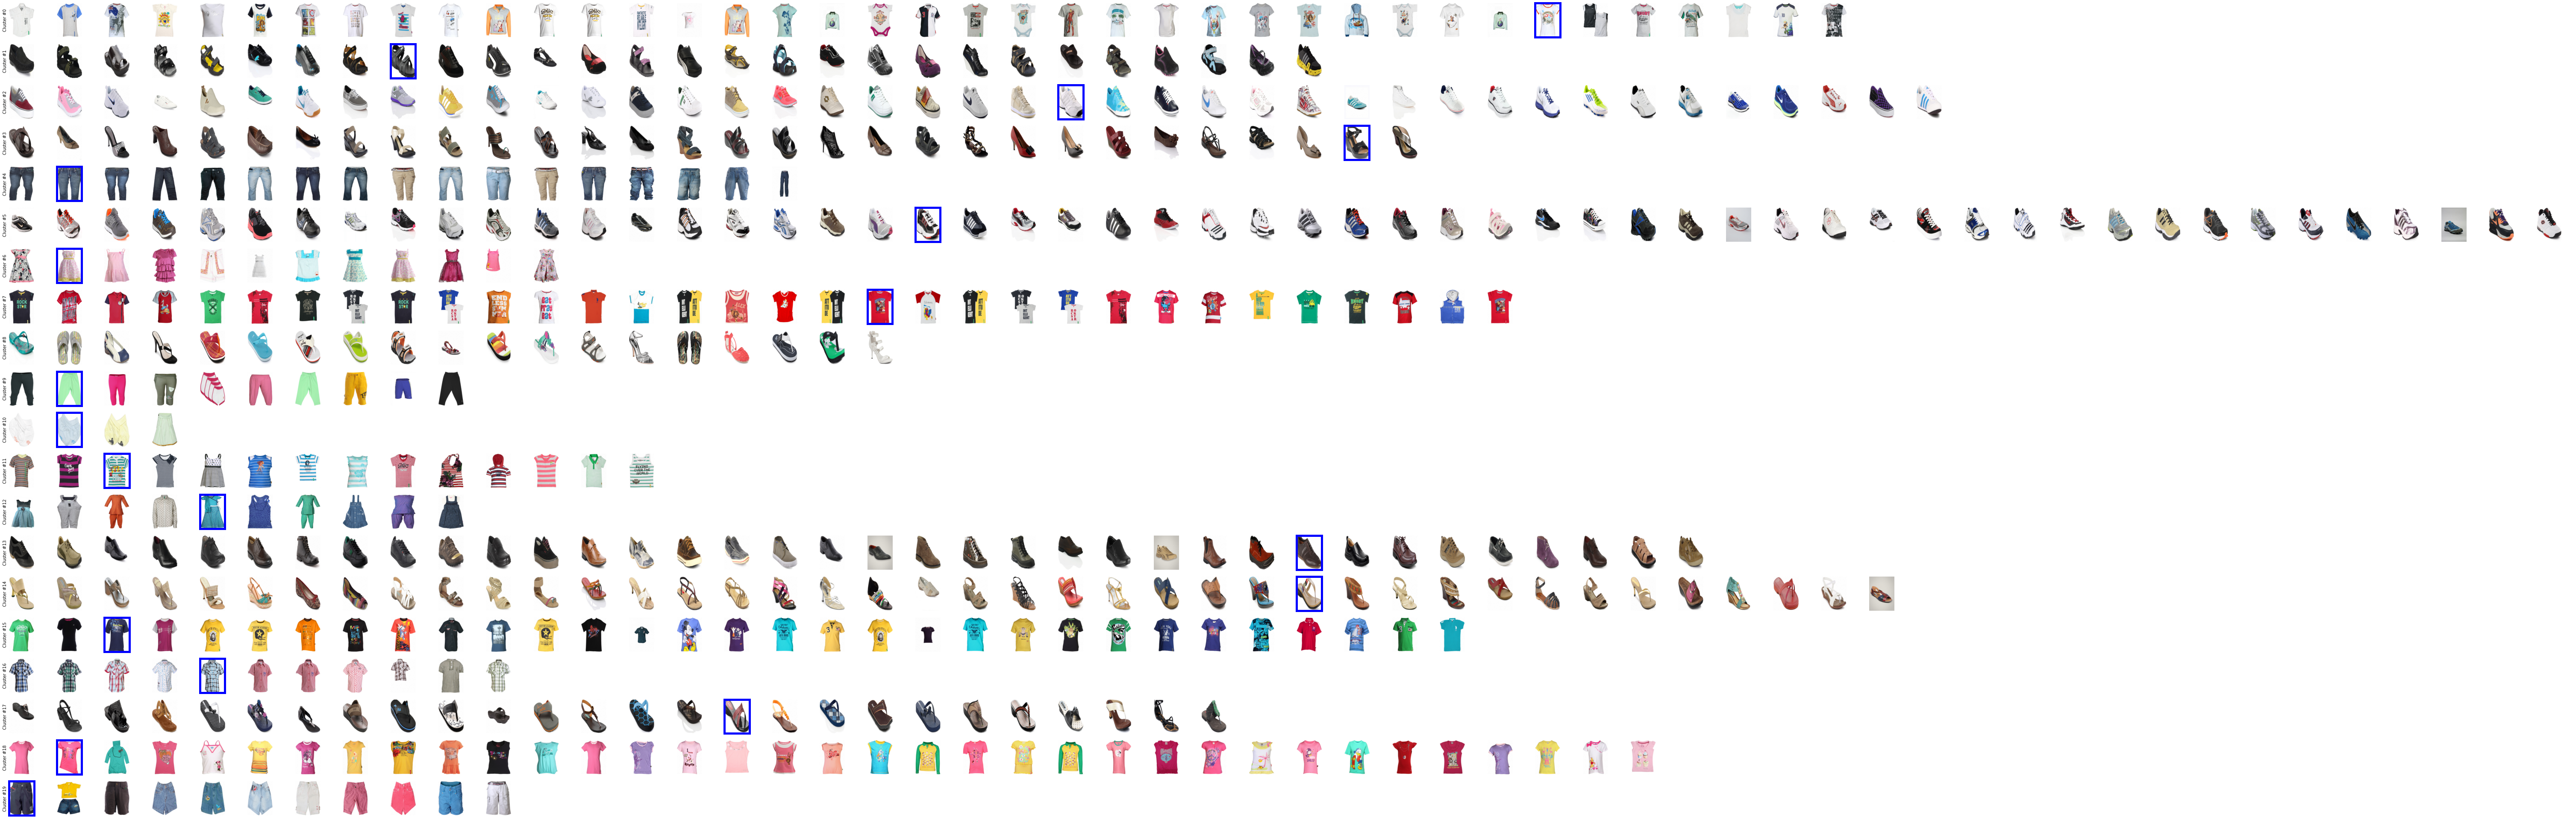

In [ ]:
maxsize = counts[0][1]  # size of the biggest cluster
fig, axes = plt.subplots(n_clusters, maxsize, figsize=(2*maxsize, 1.75*n_clusters))

# hide ticks and spines
for ax in axes.flatten():
  ax.set_xticks([])
  ax.set_yticks([])
  plt.setp(ax.spines.values(), visible=False)

# we create cluster groups by sorting and grouping by cluster labels
labels_and_idx = [(l, i) for i, l in enumerate(labels)]
labels_and_idx = sorted(labels_and_idx)
cluster_groups = itertools.groupby(labels_and_idx, key=lambda x: x[0])

# for each group, we plot the belonging images in a row
for cluster_idx, cluster in cluster_groups:
  axes[cluster_idx, 0].set_ylabel(f'Cluster #{cluster_idx}')
  
  for i, (_, sample_idx) in enumerate(cluster):
    image_np = plt.imread(db_image_paths[sample_idx])
    image_np = unpad_image(image_np)
    image_np = resize(image_np, (182, 133))
    axes[cluster_idx, i].imshow(image_np)

    # highlight the representative sample of the cluster
    if sample_idx in representatives:  
      plt.setp(axes[cluster_idx, i].spines.values(), edgecolor='blue', linewidth=5, visible=True)

plt.subplots_adjust(wspace=0)

## Image Classification via Transfer Learning


A good general representation can also be used to solve specialized tasks.
This is known as transfer learning, in which we transfer knowledge from a model pretrained on a more generic task to our specialized one.
This often has the advantage of needing way less data to solve the task.

Let's see how we can exploit the representation we extracted to build simple image classifiers.


First, we import the annotation available in our dataset.

In [ ]:
annot = pd.read_csv('data/fashion.csv', index_col=0)
annot

Gender  ...                                           ImageURL
ProductId         ...                                                   
42419      Girls  ...  http://assets.myntassets.com/v1/images/style/p...
34009      Girls  ...  http://assets.myntassets.com/v1/images/style/p...
40143      Girls  ...  http://assets.myntassets.com/v1/images/style/p...
23623      Girls  ...  http://assets.myntassets.com/v1/images/style/p...
47154      Girls  ...  http://assets.myntassets.com/v1/images/style/p...
...          ...  ...                                                ...
51755      Women  ...  http://assets.myntassets.com/v1/images/style/p...
47630      Women  ...  http://assets.myntassets.com/v1/images/style/p...
32836      Women  ...  http://assets.myntassets.com/v1/images/style/p...
35821      Women  ...  http://assets.myntassets.com/v1/images/style/p...
18553      Women  ...  http://assets.myntassets.com/v1/images/style/p...

[2906 rows x 9 columns]

We choose to build a classifier that identifies the correct **`Category`** of a depicted fashion item.
Our classifier will use the features extracted from the image as input and provide the prediction of the category.

Let's use the database and queries we previously selected as training and test sets respectively.
We split the annotations using `pandas`.

In [ ]:
db_image_ids = [int(p.stem) for p in db_image_paths]
q_image_ids = [int(p.stem) for p in q_image_paths]

db_annot = annot.loc[db_image_ids]
q_annot = annot.loc[q_image_ids]

Now, we build a simple classifier using `sklearn`.
Here, we choose a [Support Vector Machine with Radial Basis Function](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) as classifier using the default parameters set by `sklearn`.

However, you can freely choose among many ready-to-use classifiers, check [this page](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) for more info.


In [ ]:
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(db_features, db_annot.Category)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Once trained, we make predictions on our test set and compare them with annotations.

In [ ]:
q_predictions = classifier.predict(queries_features)
q_predictions

array(['Footwear', 'Apparel', 'Apparel', 'Apparel', 'Footwear',
       'Footwear', 'Footwear', 'Apparel', 'Footwear', 'Apparel',
       'Apparel', 'Apparel', 'Footwear', 'Footwear', 'Footwear'],
      dtype=object)

In [ ]:
q_annot.Category == q_predictions

ProductId
5050     True
40160    True
33309    True
34182    True
4147     True
49808    True
5654     True
41960    True
24452    True
8417     True
39330    True
8369     True
30260    True
13685    True
20805    True
Name: Category, dtype: bool

## Additional Resources

* [Transfer Learning Tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning) (TensorFlow)
* [Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) (PyTorch)
* [PyTorch Model Zoo](http://pytorch.org/serve/model_zoo.html)
